# Qubitdyne: Heterodyne detection
and state tomography.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp

import numpy as np

from qutip import *
from joblib import Parallel, delayed

## Define operators

In [2]:
N=15 # Fock space dim

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj()) # project on qubit ground state
proj1 = tensor(idc, basis(2,1).proj()) # projection on excited state

In [3]:
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def H_int(g, dt):
    Hint =  (-1j) *g*np.sqrt(dt) * (a.dag() * sm + a * sm.dag())
    return Hint

## Params

In [4]:
# number of trajectories
Ntrajs = 20000

# interaction strength
g = 0.3 # MHz

# interaction time
delta_t = 0.3 # µs
dt = delta_t

gamma = g**2

# effective interaction strength
gint = np.sqrt(gamma*delta_t)

initial_cavity = fock(N, 3)

alpha=2
# initialize cat state
initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

# get initial photon number
N_cav = num(N)
n_init = expect(N_cav, initial_cavity)

# cavity state and qubit ground state
psi0 = tensor(initial_cavity, basis(2,0))


gint

0.16431676725154984

Check needed Nmeas (number of qubit measurements per trajectory (in total, both X and Y))

In [5]:
vac = 5e-2 # finish when the cavity contains 95 % vacuum

def find_first_zero(func, tol=vac, max=1000000):
    for i in np.arange(max):
        if func(i) < tol:
            return i

def pop_time_evol(step):
        return n_init*np.exp(-step*(gint**2))

Nmeas = find_first_zero(pop_time_evol)                  
Nmeas

163

## Implements heterodyne detection

In [6]:
# This is done simply by interleaving measurements of X and Y on the qubit

# generate interaction Hamiltonian with strength gint
U_int = H_int(g, delta_t).expm()

# Number of measurements for each quadrature (X,Y)
Neach = round(Ntrajs/2)

In [7]:
nsteps = np.linspace(0,Nmeas-1,Nmeas)

weights =  np.sqrt(gamma*dt)*np.exp(-nsteps*(gint**2/2))

Neach = round(Nmeas/2)

qbrotmat = [rotateXY(np.pi/2,0),rotateXY(np.pi/2,np.pi/2)] # # qb rotation applied prior to qb measurement. [rotate to X, rotate to Y]
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

# store quadrature measurements in this list
quadmeas = []


# get integrated measurement results
def get_heterodyne_meas():

    # random number generator to simulate measurement results
    xrnd = np.random.rand(Nmeas) 
    
    results =[[] for i in range(2)]
    psi = psi0
    
    # individual qubit measurements
    for i in range(Nmeas):
        k = i % 2 # do X and Y every other round
        
        psi = qbrotmat[k] * (U_int * psi)        
        prob = expect(proj0,psi)
        
        if prob > xrnd[i]:
            # measured g
            results[k].append(-1)
            psi = (proj0 * psi).unit()
        else:
            # measured e
            results[k].append(1)
            psi = (proj1 * psi).unit()
            # go back to g
            psi = qbfeedback * psi

    return np.sum(results[0]*weights[::2]) + 1j * np.sum(results[1]*weights[1::2])

In [8]:
# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly
quadmeas = Parallel(n_jobs=-1, verbose=5, backend="loky")(delayed(get_heterodyne_meas)() for j in range(Ntrajs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 4484 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 5600 tasks      | e

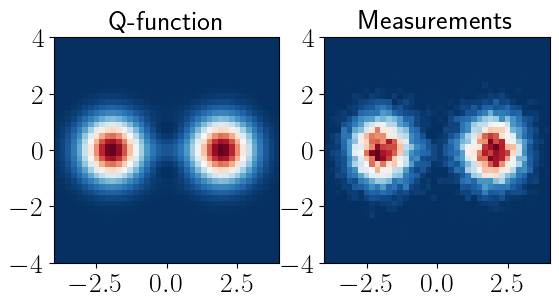

In [9]:
Nbins=40
k=4

xvec = np.linspace(-k,k,Nbins)
Q_comp = qfunc(initial_cavity, xvec, xvec, g=2) # ideal Q-function

real_meas = np.real(np.array(quadmeas))
imag_meas = np.imag(np.array(quadmeas))

hist, xedges, yedges = np.histogram2d(real_meas, imag_meas, Nbins,range=[[-k,k],[-k,k]],normed=True)

fig, ax = plt.subplots(1,2)
fig1 = ax[0].imshow(Q_comp,extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[0].set_title('Q-function')
### TRANSPOSE
hist = hist.T

fig2=ax[1].imshow(hist, extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[1].set_title('Measurements');

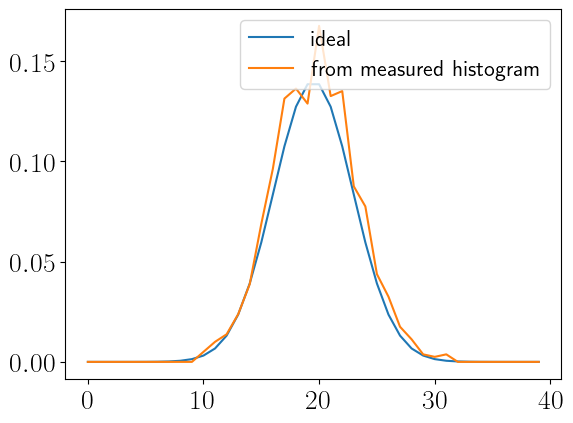

In [10]:
# compare slice through Q-func
k=8
plt.plot(Q_comp[:,k], label='ideal')
plt.plot(hist[:,k], label='from measured histogram')
plt.legend();

# Tomography

In [11]:
b=hist.flatten()

### Define Q-function measurement operators

In [12]:
def qfunc_ops(hilbert_size, beta):
    
    # need the larger Hilbert space to not get erroneous operators for large beta
    op = coherent_dm(50, beta)/np.pi
    op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        
    return op

### Construct the operator basis: Fock basis
The list `basis_dms` contains all $\Omega_k$

In [13]:
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

In [14]:
# Use midpoint of grid as phase space points
xvec2 = []
for idx, x in enumerate(xedges[:-1]):
    xvec2.append((x + xedges[idx+1])/2)

yvec2 = []
for idx, y in enumerate(yedges[:-1]):
    yvec2.append((y + yedges[idx+1])/2)
   

xvec = xvec2
yvec = yvec2
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()

In [15]:
Pis = Parallel(n_jobs=-1, verbose=5, backend="multiprocessing")(delayed(qfunc_ops)(N,beta) for beta in betas)

def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 914 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1184 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 1490 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   29.0s finished
[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 8160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 133088 tasks      | elapsed:    2.2s
[

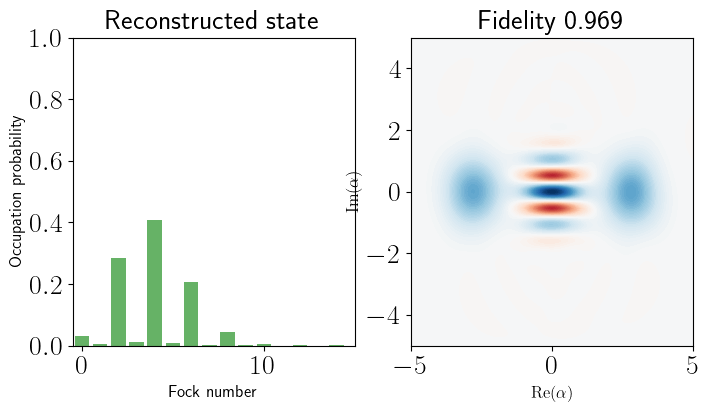

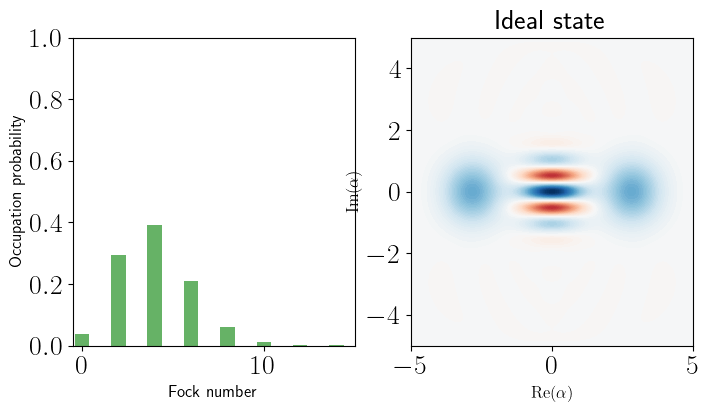

In [16]:
### Visualize results

# The result may vary depending on the random number generation.

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));

plot_wigner_fock_distribution(initial_cavity, alpha_max=5)
plt.title("Ideal state");